# In this notebook, LSTM multivaraite model will be explored

In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
keras = tf.keras
from sklearn.model_selection import train_test_split

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

import pickle
from datetime import datetime

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## LSTM

#### Reload the data

The plan:

First run only price data to do a univariate LSTM ... DONE
Check results for all data including 2020 ... Poor Results

Check results for 2019 data only ... DONE, good results
Compare predictions with known 2020 data ... DONE dood results

Then do multivariate with price, offer qty and sold qty, for 1 tea category
Then add all categories

In [8]:
def get_timestamp():
    timestamp =   str(datetime.now().year) + '_'\
                + str(datetime.now().month).zfill(2) + '_'\
                + str(datetime.now().day).zfill(2) + '_'\
                + str(datetime.now().hour).zfill(2) + '_'\
                + str(datetime.now().minute).zfill(2) + '_'\
                + str(datetime.now().second).zfill(2)
    return timestamp

In [9]:
# load dataset
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv', header=0, index_col=0)
df_CHN_CTC_dust = pd.read_csv('../Data/df_CHN_CTC_dust.csv', header=0, index_col=0)
df_CHN_Ortho_leaf = pd.read_csv('../Data/df_CHN_Ortho_leaf.csv', header=0, index_col=0)
df_CHN_Ortho_dust = pd.read_csv('../Data/df_CHN_Ortho_dust.csv', header=0, index_col=0)

In [10]:
# # chop out 2020 data
# df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_CTC_dust = df_CHN_CTC_dust[pd.to_datetime(df_CHN_CTC_dust.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_leaf = df_CHN_Ortho_leaf[pd.to_datetime(df_CHN_Ortho_leaf.index) < pd.to_datetime('2020-01-01')]
# df_CHN_Ortho_dust = df_CHN_Ortho_dust[pd.to_datetime(df_CHN_Ortho_dust.index) < pd.to_datetime('2020-01-01')]

In [11]:
def plot_oqty_sqty_avgp(df, category, city):

    fig, axs = plt.subplots(3, figsize=(15, 10))

    axs[0].plot(pd.to_datetime(df.index), df[category + '_offer_qty'],'*-', c='r',
                label=category.upper() + ' Offer Qty')
    axs[0].set_title(category.upper() + ' Offer Qty - ' + city)
    axs[0].set_ylabel('Kgs')
    axs[0].legend(loc='best')
    axs[0].tick_params(rotation=75, axis='x')
                            
    axs[1].plot(pd.to_datetime(df.index), df[category + '_sold_qty'], '*-', c='g',
                label=category.upper() + ' Sold Qty')
    axs[1].set_title(category.upper() + ' Sold Qty - ' + city)
    axs[1].set_ylabel('Kgs')
    axs[1].legend(loc='best')
    axs[1].tick_params(rotation=75, axis='x')
                            
    axs[2].plot(pd.to_datetime(df.index), df[category + '_avg_price'],'*-', c='b',
                label=category.upper() + ' Avg Price')
    axs[2].set_title(category.upper() + ' Avg Price - ' + city)
    axs[2].set_ylabel('Kgs')
    axs[2].legend(loc='best')
    axs[2].tick_params(rotation=75, axis='x')


    fig.tight_layout()
    fig.savefig('../Images/' + category.upper() + '_' + city + '_oqty_sqty_avgp' + get_timestamp())
                        
                        
# values = dataset.values
# # specify columns to plot
# groups = [0, 1, 2, 3, 5, 6, 7]
# i = 1
# # plot each column
# pyplot.figure()
# for group in groups:
# 	pyplot.subplot(len(groups), 1, i)
# 	pyplot.plot(values[:, group])
# 	pyplot.title(dataset.columns[group], y=0.5, loc='right')
# 	i += 1
# pyplot.show()

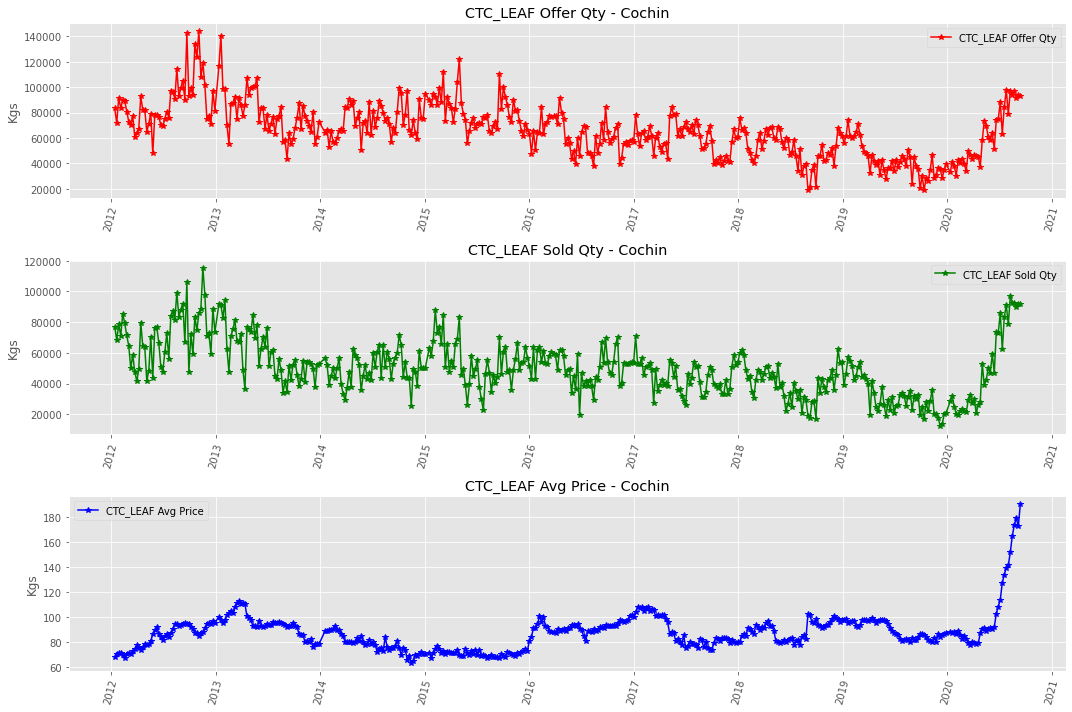

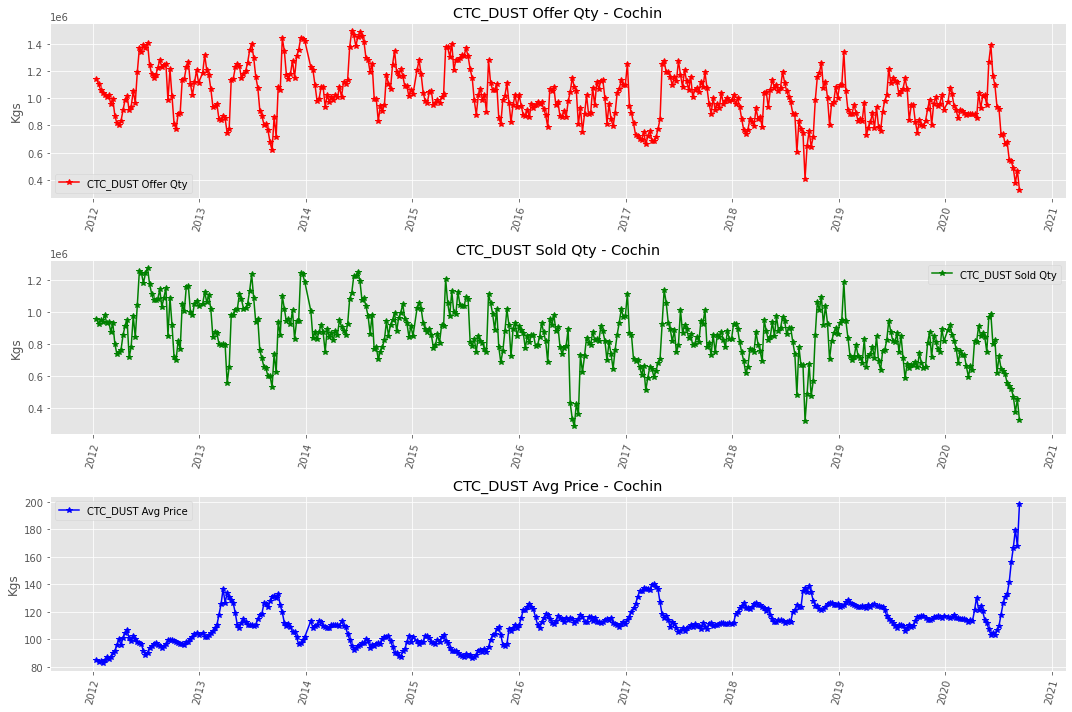

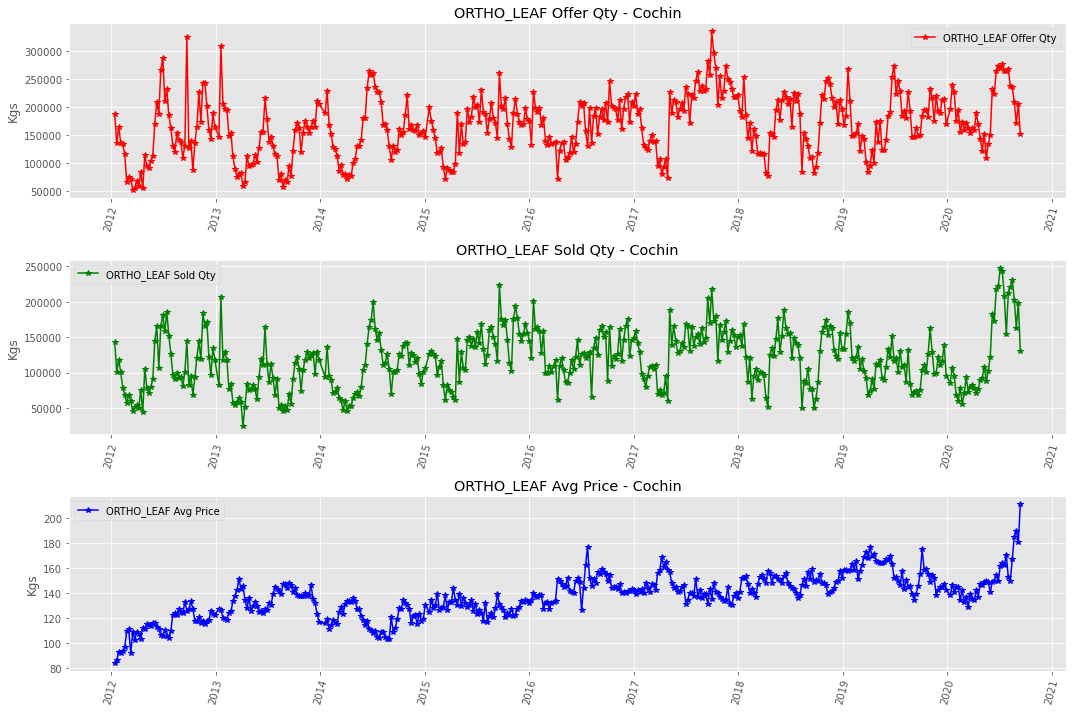

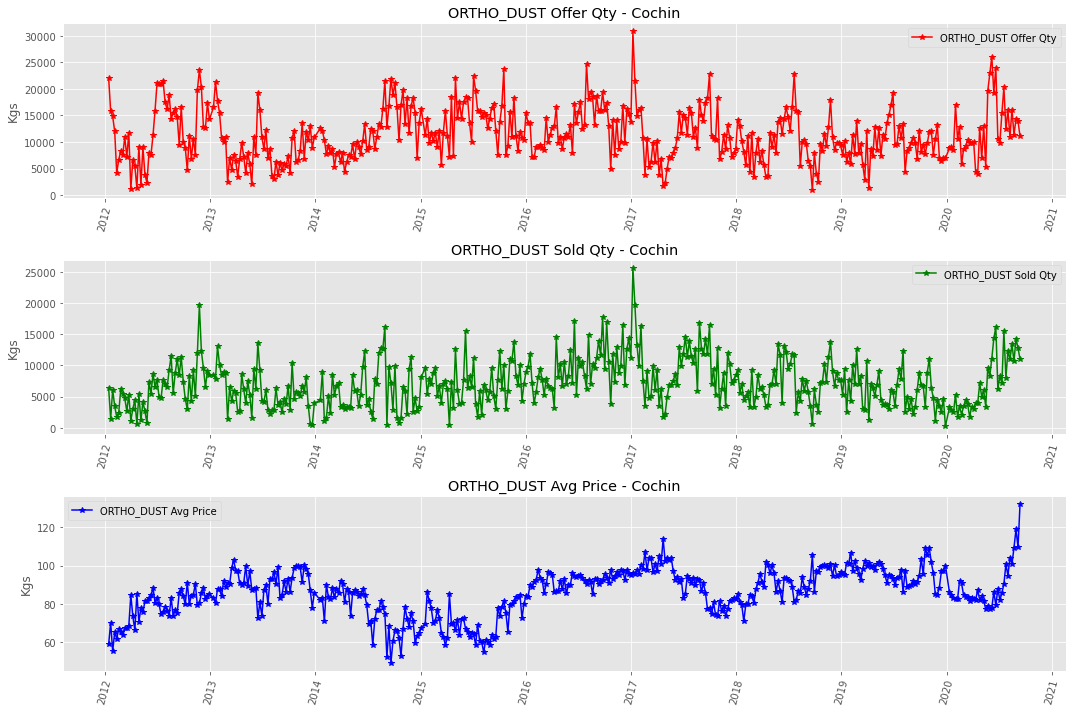

In [12]:
plot_oqty_sqty_avgp(df_CHN_CTC_leaf, 'ctc_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_CTC_dust, 'ctc_dust', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_leaf, 'ortho_leaf', 'Cochin')
plot_oqty_sqty_avgp(df_CHN_Ortho_dust, 'ortho_dust', 'Cochin')

## Univariate

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 52 values followed by one value (for the output) along our time-series data.

In [20]:
# Set up the first price series
price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = price_series.index #pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
# price_series.index = time_series
time_series

Index(['14-Jan-12', '21-Jan-12', '28-Jan-12', '4-Feb-12', '11-Feb-12',
       '18-Feb-12', '25-Feb-12', '3-Mar-12', '10-Mar-12', '17-Mar-12',
       ...
       '11-Jul-20', '18-Jul-20', '25-Jul-20', '1-Aug-20', '8-Aug-20',
       '15-Aug-20', '22-Aug-20', '29-Aug-20', '5-Sep-20', '12-Sep-20'],
      dtype='object', name='week_ending', length=448)

In [21]:
def windowize_data(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + np.arange(n_predictions)[:, None]
    x = data[indices, None]
    return x, y

Then we'll write a function split the data into training and testing sets. Because it's time-series data we have to do that sequentially rather than shuffling it. They should be completely separate and not overlap, so the the training data isn't used for testing.

In [25]:
def split_and_windowize(data, n_prev, fraction_test=0.05):
    n_predictions = len(data) - 2*n_prev
    print('n_predictions = ', n_predictions)
    input()
    
    n_test  = int(fraction_test * n_predictions)
    n_train = n_predictions - n_test   
    
    x_train, y_train = windowize_data(data[:n_train], n_prev)
    x_test, y_test = windowize_data(data[n_train:], n_prev)
    return x_train, x_test, y_train, y_test

In [26]:
df_CHN_CTC_leaf

,year,serial_no,ctc_leaf_offer_qty,ctc_leaf_sold_qty,ctc_leaf_avg_price
week_ending,,,,,
14-Jan-12,2012,2,83325.00,77015.00,68.03
21-Jan-12,2012,3,71897.00,68187.00,70.11
28-Jan-12,2012,4,91279.00,78695.00,70.73
4-Feb-12,2012,5,83746.00,71188.00,70.63
11-Feb-12,2012,6,89650.00,85480.00,69.23
...,...,...,...,...,...
15-Aug-20,2020,33,93637.00,92640.00,165.10
22-Aug-20,2020,34,96829.00,92338.00,174.03
29-Aug-20,2020,35,91799.00,89785.00,179.36


In [27]:
n_prev = 6

x_train, x_test, y_train, y_test = split_and_windowize(price_series.values, n_prev)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

# ((363, 10, 3), (29, 10, 3), (363, 3), (29, 3))

n_predictions =  436



((409, 6, 1), (27, 6, 1), (409,), (27,))

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [28]:
# LSTM_price_model = keras.Sequential()

# LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

# LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

# LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

# LSTM_price_model.compile(optimizer='adam', loss='mse')

In [29]:
LSTM_price_model = keras.Sequential()

LSTM_price_model.add(keras.layers.LSTM(52, input_shape=(n_prev, 1), return_sequences=True))

LSTM_price_model.add(keras.layers.Dropout(0.1))

LSTM_price_model.add(keras.layers.LSTM(52, return_sequences=False))

LSTM_price_model.add(keras.layers.Dense(1, activation='relu')) # 'linear'

LSTM_price_model.compile(optimizer='adam', loss='mse')

In [30]:
LSTM_price_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 6, 52)             11232     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 52)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 52)                21840     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 53        
Total params: 33,125
Trainable params: 33,125
Non-trainable params: 0
_________________________________________________________________


In [46]:
LSTM_price_model_history = LSTM_price_model.fit(x_train, y_train, batch_size=10, epochs=300)


Epoch 1/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.2601
Epoch 2/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.6620
Epoch 3/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.5971
Epoch 4/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.6676
Epoch 5/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.8186
Epoch 6/300
409/409 [==============================] - 1s 2ms/sample - loss: 5.2433
Epoch 7/300
409/409 [==============================] - 1s 2ms/sample - loss: 5.1643
Epoch 8/300
409/409 [==============================] - 1s 2ms/sample - loss: 5.0030
Epoch 9/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.8489
Epoch 10/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.7082
Epoch 11/300
409/409 [==============================] - 1s 2ms/sample - loss: 3.9269
Epoch 12/300
409/409 [==============================] - 1s 2ms/sample - lo

409/409 [==============================] - 1s 2ms/sample - loss: 3.8239
Epoch 193/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.5903
Epoch 194/300
409/409 [==============================] - 1s 2ms/sample - loss: 5.2369
Epoch 195/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.3552
Epoch 196/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.7354
Epoch 197/300
409/409 [==============================] - 1s 2ms/sample - loss: 3.8363
Epoch 198/300
409/409 [==============================] - 1s 2ms/sample - loss: 3.9004
Epoch 199/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.4082
Epoch 200/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.0536
Epoch 201/300
409/409 [==============================] - 1s 2ms/sample - loss: 6.0059
Epoch 202/300
409/409 [==============================] - 1s 2ms/sample - loss: 4.4284
Epoch 203/300
409/409 [==============================] - 1s 2ms/samp

In [47]:
# ## Pickle the model
# # Save the Modle to file in the current working directory
# timestamp =   str(datetime.now().year) + '_'\
#             + str(datetime.now().month).zfill(2) + '_'\
#             + str(datetime.now().day).zfill(2) + '_'\
#             + str(datetime.now().hour).zfill(2) + '_'\
#             + str(datetime.now().minute).zfill(2) + '_'\
#             + str(datetime.now().second).zfill(2)


# pickled_model_filename = '../Models/LSTM_price_model_' + LSTM_price_model.name + '_' + timestamp + '.pkl'  

# with open(pickled_model_filename, 'wb') as file:  
#     pickle.dump(LSTM_price_model, file)

# # Load the Model back from file
# with open(pickled_model_filename, 'rb') as file:  
#     pickled_LSTM_price_model = pickle.load(file)

# pickled_LSTM_price_model

## Predictions from LSTM Univariate

In [48]:
y_pred = LSTM_price_model.predict(x_test)
y_pred

array([[ 78.53679 ],
       [ 80.71495 ],
       [ 81.30217 ],
       [ 79.286194],
       [ 77.82948 ],
       [ 82.24678 ],
       [ 79.151436],
       [ 82.99077 ],
       [ 90.282455],
       [ 88.5919  ],
       [ 88.10699 ],
       [ 90.8273  ],
       [ 92.43994 ],
       [ 91.17848 ],
       [ 92.22747 ],
       [ 96.98732 ],
       [104.17345 ],
       [107.566284],
       [108.47665 ],
       [109.04506 ],
       [109.043045],
       [108.974144],
       [108.92715 ],
       [108.903824],
       [108.885   ],
       [108.875175],
       [108.83228 ]], dtype=float32)

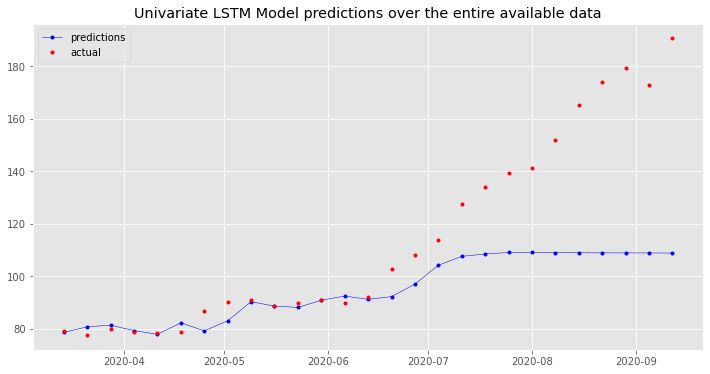

In [49]:
# Plot the predictions (one step ahead) against the test data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_pred, 'b.-', label='predictions', lw=0.5)
ax.plot(pd.to_datetime(time_series[-len(y_pred):]), y_test, 'r.', label='actual')
ax.set_title('Univariate LSTM Model predictions over the entire available data')
fig.savefig('../Images/UnivariateLSTMModelPredictions_testdata_entire_available' + get_timestamp())
ax.legend();

In [50]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [51]:
# Calaculate MAPE
print(f'MAPE for known data (before 2020) = {mape(price_series, y_pred)}')

MAPE for known data (before 2020) = 18.872366850870822


In [52]:
LSTM_price_model_history.history

{'loss': [4.2601485925665115,
  4.662006602602075,
  4.597089595783019,
  4.6675716676455545,
  4.818561056715352,
  5.2433465836537785,
  5.164296285447398,
  5.003029644343556,
  4.848917539078915,
  4.708177540296448,
  3.9268894495765854,
  4.726485966178782,
  3.960820825875243,
  4.095942280986199,
  3.5939714182851366,
  4.170141596665884,
  6.12029028172015,
  4.920911442388241,
  4.2824840248359735,
  5.638526167438199,
  5.022523538990534,
  8.051398437588606,
  4.456141394915965,
  5.43671734059061,
  5.00614175761533,
  4.483272874850807,
  4.711462942487162,
  3.644374172961508,
  4.852840262695163,
  3.850580773318601,
  4.076175582438052,
  5.139624598848208,
  5.135940838559624,
  4.623680271554401,
  4.179504978627622,
  5.3179415945318915,
  4.5518882950827075,
  5.914138203436704,
  4.288868445930388,
  4.215168117019541,
  5.020544163755217,
  3.911169873473114,
  4.579483875144081,
  5.035780885691747,
  4.366969128984111,
  3.8363639681729826,
  4.858878294383984,

In [53]:
def plot_train_history(history, title):
    loss = history.history['loss']
#     val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(20,10))

    plt.plot(epochs, loss, 'b', label='Training loss')
#     plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


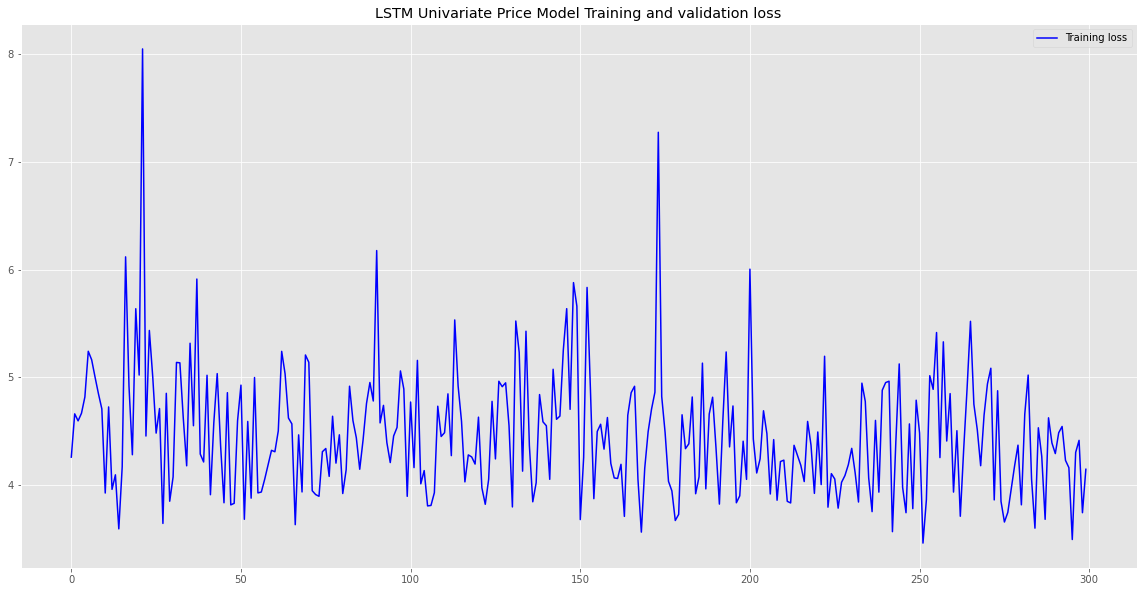

In [54]:
plot_train_history(LSTM_price_model_history, 'LSTM Univariate Price Model Training and validation loss')

In [55]:
# multi-step encoder-decoder lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

Using TensorFlow backend.


In [56]:
# define dataset
X = array([[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]])
y = array([[40,50],[50,60],[60,70],[70,80]])

In [57]:
X, y

(array([[10, 20, 30],
        [20, 30, 40],
        [30, 40, 50],
        [40, 50, 60]]),
 array([[40, 50],
        [50, 60],
        [60, 70],
        [70, 80]]))

In [58]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape((y.shape[0], y.shape[1], 1))

In [59]:
X, y

(array([[[10],
         [20],
         [30]],
 
        [[20],
         [30],
         [40]],
 
        [[30],
         [40],
         [50]],
 
        [[40],
         [50],
         [60]]]),
 array([[[40],
         [50]],
 
        [[50],
         [60]],
 
        [[60],
         [70]],
 
        [[70],
         [80]]]))

In [60]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))
model.add(RepeatVector(2))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([50, 60, 70])
x_input = x_input.reshape((1, 3, 1))
yhat = model.predict(x_input, verbose=0)
print(yhat)


[[[76.5577 ]
  [91.54628]]]
